## Import Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os,glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:

%matplotlib inline

import fastai

from fastai import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback


In [3]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

## Loading the Data

In [4]:
from numpy import genfromtxt
path_vad = '/home/liuchang/PDANet/IAPS/IAPS_VAD.txt'
mat_vad = pd.read_csv(path_vad,sep='\t',names=['image','v','a','d'])

In [8]:
mat_vad['image']=['/path/to/dataset/IAPS/Dataset/{}.jpg'.format(i) for i in mat_vad['image']]

In [9]:
mat_vad['v']=(mat_vad['v']-1)/8
mat_vad['a']=(mat_vad['a']-1)/8
mat_vad['d']=(mat_vad['d']-1)/8

In [10]:
mat_vad.head()

,image,v,a,d
0,/path/to/dataset/IAPS/Dataset//home/liuchang/P...,-0.078906,-0.050469,-0.074531
1,/path/to/dataset/IAPS/Dataset//home/liuchang/P...,-0.074063,-0.046563,-0.079687
2,/path/to/dataset/IAPS/Dataset//home/liuchang/P...,-0.076719,-0.052969,-0.071406
3,/path/to/dataset/IAPS/Dataset//home/liuchang/P...,-0.073438,-0.055313,-0.069375
4,/path/to/dataset/IAPS/Dataset//home/liuchang/P...,-0.080156,-0.044844,-0.082344


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8202373550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f81ffb7e438>]], dtype=object)

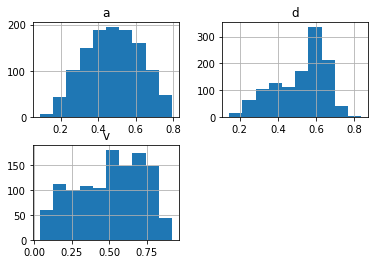

In [8]:
mat_vad.hist()

## Preparing the Data for Fastai Models

In [11]:
tfms = get_transforms(max_lighting=None, do_flip=True)

data_big = ImageList.from_df(mat_vad, '/', cols=['image'], folder ='.').split_by_rand_pct(0.2, seed=42).label_from_df(label_cls=FloatList,cols=['v','a','d']).transform(tfms, size=224).databunch(bs=24).normalize(imagenet_stats)

## A look at the Images

In [ ]:
data_big.show_batch(4, figsize=(12,12))

## Fastai Modelling

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet50(pretrained=True).children())[:-1]
        layers += [Flatten()]
        layers += [nn.Linear(2048,128),nn.ReLU(),nn.Linear(128,3)]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        out=self.model(x)
        return out
          # could add 116*torch.sigmoid

In [15]:
model = Model()

In [16]:
learn = Learner(data_big, model, model_dir = "/path/to/models/model_IAPS/", bn_wd=False,metrics=root_mean_squared_error,
               callback_fns=[ShowGraph])
# learn.loss_func = L1LossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 4.79E-03


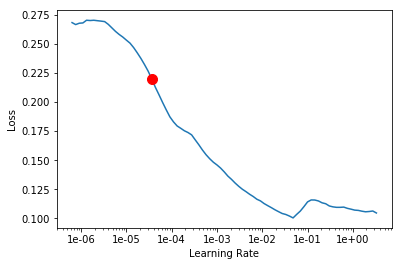

In [18]:
import fastai
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [19]:
# lr = 4e-5
lr=learn.recorder.min_grad_lr
wd = lr/5
epoch=100

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.223325,0.192066,0.437771,00:08
1,0.170728,0.126881,0.355616,00:09
2,0.120621,0.073610,0.270680,00:08
3,0.079050,0.042032,0.204634,00:09
4,0.051813,0.030624,0.174926,00:09
5,0.036998,0.027725,0.166439,00:09
6,0.028358,0.025931,0.160841,00:09
7,0.023082,0.024423,0.155988,00:09
8,0.019497,0.023405,0.152431,00:09
9,0.016265,0.022405,0.149237,00:09


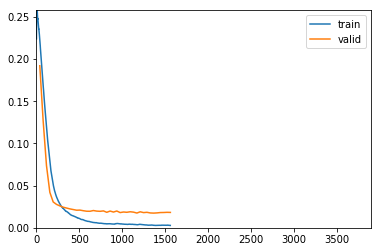

Better model found at epoch 0 with valid_loss value: 0.19206584990024567.
Better model found at epoch 1 with valid_loss value: 0.1268807351589203.
Better model found at epoch 2 with valid_loss value: 0.07361017912626266.
Better model found at epoch 3 with valid_loss value: 0.042032234370708466.
Better model found at epoch 4 with valid_loss value: 0.030623840168118477.
Better model found at epoch 5 with valid_loss value: 0.02772476337850094.
Better model found at epoch 6 with valid_loss value: 0.02593054622411728.
Better model found at epoch 7 with valid_loss value: 0.024422956630587578.
Better model found at epoch 8 with valid_loss value: 0.023405179381370544.
Better model found at epoch 9 with valid_loss value: 0.022405050694942474.
Better model found at epoch 10 with valid_loss value: 0.02163204923272133.
Better model found at epoch 11 with valid_loss value: 0.020847037434577942.
Better model found at epoch 13 with valid_loss value: 0.020235687494277954.
Better model found at epoch 1

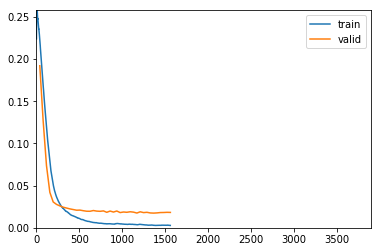

In [20]:
# from fastai.callbacks.flat_cos_anneal import FlatCosAnnealScheduler
# learn.fit_one_cycle(epoch, max_lr=lr,wd=wd,callbacks=[SaveModelCallback(learn)])
learn.fit_one_cycle(epoch, lr, wd=wd, callbacks=[SaveModelCallback(learn),EarlyStoppingCallback(learn,patience=4)])

In [27]:
learn.save('resnet50_vad_IAPS_0.017423')
# learn.load('first_head_resnet34')